c:\Users\jabar\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Best score: 35172.48062378991: 100%|██████████| 200/200 [39:42<00:00, 11.91s/it]  


best parameters: {'d': 0, 'p': 26, 'q': 29, 'trend': 'ct'}
best loss: 35172.48062378991
final model: (26, 0, 29) ct
MSE error is: 35172.48062378991


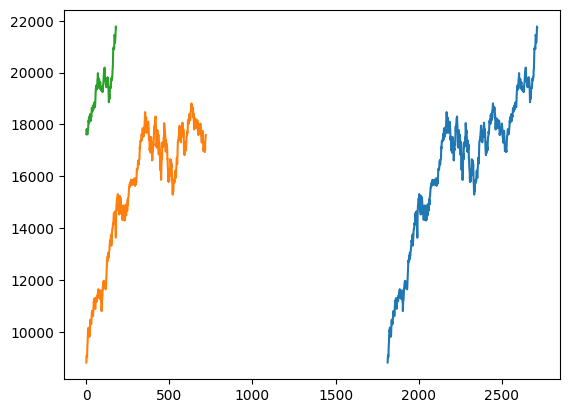

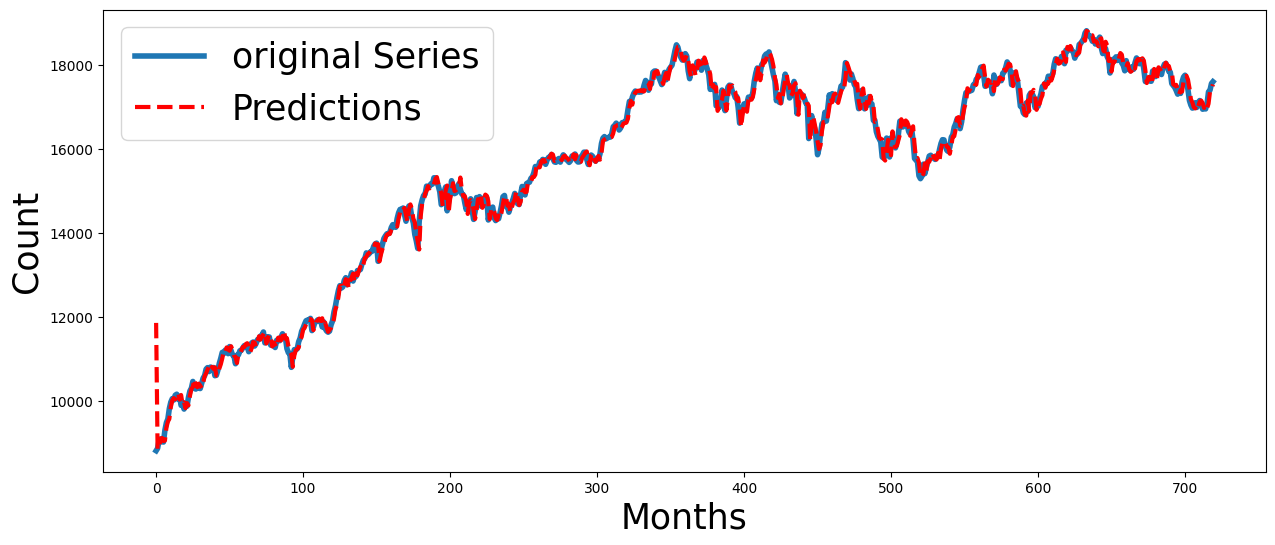

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import helperfunc as hf
import preprocess_a as pp

from mango import scheduler, Tuner
from matplotlib import pyplot as plt

raw = pd.read_csv("NIFTY-50.csv")
raw = pp.remove(raw)

raw = raw.iloc[1800:]
X_train, X_test, y_train, y_test = hf.test_train_split_arima(raw)
X_train = X_train.reset_index().drop('index',axis=1)
X_test = X_test.reset_index().drop('index',axis=1)
y_train = y_train.reset_index().drop('index',axis=1)
y_test = y_test.reset_index().drop('index',axis=1)

plt.plot(raw['Close'])
plt.plot(y_train)
plt.plot(y_test)


# defining the parameters space
param_space = dict(p = range(0,30),
                   d = range(0,30),
                   q = range(0,30),
                   trend=['n', 'c', 't' , 'ct'])

# Training the ARIMA model
def arima_obj(args_list):
    global close_vals
    params_evaluated = []
    result = []

    for params in args_list:
        try:
            p,d,q = params['p'], params['d'], params['q']
            trend = params['trend']

            model = ARIMA (close_vals, order=(p,d,q), trend = trend)
            predictions = model.fit()

            mse = mean_squared_error(close_vals, predictions.fittedvalues)
            params_evaluated.append(params)
            result.append(mse)
        except:
            params_evaluated.append(params)
            result.append(1e5)
    
    return params_evaluated, result

def plot_arima(data_values, order = (1,1,1), trend = 'c'):
    print('final model:', order, trend)
    model = ARIMA(data_values, order=order, trend = trend)
    results = model.fit()
    
    error = mean_squared_error(data_values, results.fittedvalues)   
    print('MSE error is:', error)
    
    from matplotlib import pyplot as plt
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(6)
    plt.plot(data_values, label = "original Series", linewidth = 4)
    plt.plot(results.fittedvalues, color='red', label = "Predictions", linestyle='dashed', linewidth = 3)
    plt.legend(fontsize = 25)
    plt.xlabel('Months', fontsize = 25)
    plt.ylabel('Count', fontsize = 25)
    plt.show()



close_vals = list(y_train['Close'])
conf_dict = dict()
conf_dict['num_iteration'] = 200


tuner = Tuner(param_space, arima_obj, conf_dict)
results = tuner.minimize()


print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

order = (results['best_params']['p'], results['best_params']['d'], results['best_params']['q'])
plot_arima(close_vals, order=order, trend = results['best_params']['trend'])